<a href="https://colab.research.google.com/github/shahchayan9/Clustering/blob/main/Udio_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Install Required Libraries
!pip install torch torchvision torchaudio -q
!pip install transformers -q
!pip install matplotlib scikit-learn librosa -q



In [ ]:
# Step 2: Import Required Libraries
import torch
import librosa
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from transformers import Wav2Vec2Processor, Wav2Vec2Model

In [ ]:
# Step 3: Load Pretrained Wav2Vec2 Model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [ ]:
# Step 4: Generate Synthetic Audio Data
def generate_sine_wave(freq, duration, sr=16000):
    """Generate a sine wave for a given frequency and duration."""
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    audio = 0.5 * np.sin(2 * np.pi * freq * t)
    return audio

# Parameters
sr = 16000  # Sampling rate
duration = 2.0  # Duration in seconds
frequencies = [200, 400, 600, 800]  # Different frequencies to simulate audio signals
audio_signals = [generate_sine_wave(freq, duration, sr) for freq in frequencies]

In [ ]:
# Step 5: Preprocess Audio and Generate Embeddings
def extract_embeddings(audio, sr=16000):
    """Extract audio embeddings using Wav2Vec2."""
    inputs = processor(audio, sampling_rate=sr, return_tensors="pt", padding=True)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    # Average across the time dimension to create 2D embeddings
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

embeddings = np.array([extract_embeddings(signal, sr)[0] for signal in audio_signals])


In [ ]:
# Step 6: Perform Clustering
num_clusters = 2  # Adjust this based on your dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)


In [ ]:
# Step 7: Clustering Quality Measures
sil_score = silhouette_score(embeddings, labels)
print(f"Silhouette Score: {sil_score:.3f}")

Silhouette Score: 0.136


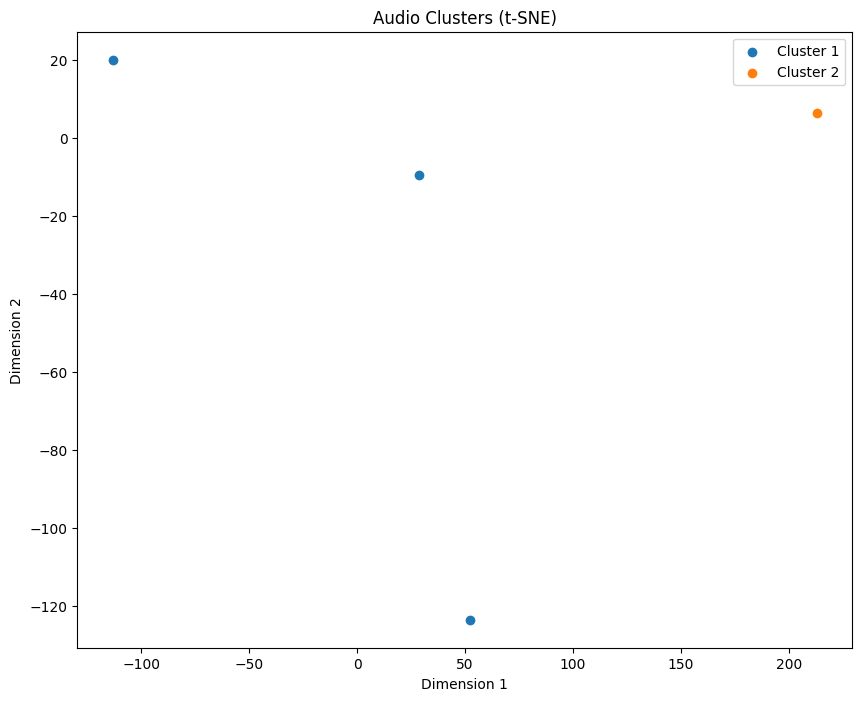

In [ ]:
# Step 8: Visualize Clusters Using t-SNE
# Reduce dimensionality for visualization
tsne = TSNE(n_components=2, perplexity=2, random_state=42)  # Perplexity must be < number of samples
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot the clusters
plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
    cluster_indices = np.where(labels == cluster)
    plt.scatter(
        reduced_embeddings[cluster_indices, 0],
        reduced_embeddings[cluster_indices, 1],
        label=f"Cluster {cluster + 1}"
    )
plt.title("Audio Clusters (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

In [ ]:
# Step 9: Print Cluster Assignments
for cluster in range(num_clusters):
    print(f"Cluster {cluster + 1}:")
    for idx, freq in enumerate(frequencies):
        if labels[idx] == cluster:
            print(f"  - Audio with frequency {freq} Hz")
    print()


Cluster 1:
  - Audio with frequency 200 Hz
  - Audio with frequency 400 Hz
  - Audio with frequency 600 Hz

Cluster 2:
  - Audio with frequency 800 Hz

